In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

In [2]:
def simulate_simple_markov_chain(N, mu, sigma, alpha, beta):
    
    #Simple lambda to sample from a Markov chain, given a current state x
    markov_sample = lambda x: np.random.choice(range(3), size = 1, p = probs[x])[0]
    initial_probs = np.array([0.7, 0.3, 0])
    state = np.random.choice(range(3), size = 1, p = initial_probs)[0]
    y = [0]
    for t in range(1,N):
        curr_p = alpha*np.exp(beta*t/20)
        if curr_p > 1:
            print(i, curr_p)
        probs = np.array([[(0.95-curr_p), 0.05, curr_p], 
                          [0.1, 0.85, 0.05]
                         ]
                        )
        state = markov_sample(state)
        if state == 0:
            dy = np.abs(np.random.normal(size = 1, loc = mu[0], scale = sigma[0]))[0]
            y.append(y[t-1] + dy)
        elif state == 1:
            dy = np.abs(np.random.normal(size = 1, loc = mu[1], scale = sigma[1]))[0]
            y.append(y[t-1] + dy)
        elif state == 2:
            dy = np.random.normal(size = 1, loc = mu[2], scale = sigma[2])[0]
            y.append(y[t-1] + dy)
            break
    return y

In [3]:
true_alpha = np.exp(-7)
true_beta = 0.1
true_mu = np.array([0.2, 0, -5])
true_sigma = np.array([0.1, 0.01, 0.01])

In [4]:
simulated_process = []
for i in range(100):
    simulated_process.append(simulate_simple_markov_chain(N=1000,
                                                          mu=true_mu,
                                                          sigma=true_sigma,
                                                          alpha=true_alpha,
                                                          beta=true_beta))

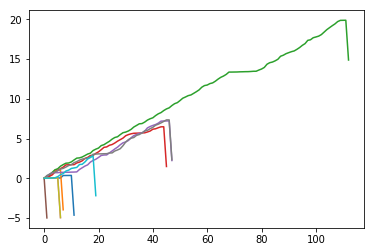

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(10):
    plt.plot(simulated_process[i])

In [6]:
df = pd.DataFrame(simulated_process)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,578,579,580,581,582,583,584,585,586,587
0,0,0.004969,0.013858,0.024201,0.034552,0.037088,0.038441,0.344696,0.349678,0.352139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.272048,0.430247,0.690562,1.026680,1.033594,1.046901,-3.966677,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.247874,0.368414,0.750271,1.069018,1.198047,1.518999,1.719132,1.894991,1.921183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.028096,0.250809,0.432751,0.793384,0.988265,1.205562,1.397962,1.682572,1.692789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.247555,0.517263,0.703797,0.705219,0.708680,0.737726,0.746820,0.755255,0.755673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
import pymc3 as pm
import theano.tensor as tt
import theano

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [8]:
eta_ = tt.dtensor3("eta_")
eta0 = np.random.rand(1000, 100, 3)
eta_.tag.test_value = eta0

xi_ = tt.dmatrix("xi_")
xi_.tag.test_value = np.array([[1, 0, 0]] * 100)
xi_out = tt.dmatrix("xi_out")
xi_out.tag.test_value = np.array([[1, 0, 0]] * 100)
print(xi_out.tag.test_value.shape)
ft_out = tt.dvector("ft_out")
ft_out.tag.test_value = np.array([0] * 100)
print(ft_out.tag.test_value.shape)

(100, 3)
(100,)


In [9]:
p = np.zeros((1000, 100, 2, 3))
for i in range(1000):
    for j in range(100):
        p[i, j, 0, 0] = 0.95 - np.exp(-6) * np.exp(0.05*i/20)
        p[i, j, 0, 1] = 0.05
        p[i, j, 0, 2] = np.exp(-6) * np.exp(0.05*i/20)
        p[i, j, 1, 0] = 0.01
        p[i, j, 1, 1] = 0.94
        p[i, j, 1, 2] = 0.05

In [10]:
P_curr = p[0]

In [11]:
ft2 = np.zeros((1000, 100))
xi2 = np.zeros((1000, 100, 3))

In [12]:
def ftfunc(P_curr, xi, eta):
    xi2 = np.zeros((100, 3))
    for i in range(100):
        xi2[i] = eta[i] * (np.dot(P_curr[i].T, xi[i, 0:2]))
    return xi2

In [13]:
xi2[0] = ftfunc(P_curr, np.asarray([[1, 0, 0]] * 100), eta0[0])

In [14]:
ft2[0] = xi2[0].sum(axis=1)

In [15]:
xi2[0, :, 0] = xi2[0, :, 0]/ft2[0]
xi2[0, :, 1] = xi2[0, :, 1]/ft2[0]
xi2[0, :, 2] = xi2[0, :, 2]/ft2[0]
xi2[0, 0, :]

array([0.80080394, 0.19509167, 0.00410439])

In [16]:
np.dot(P_curr[0].T, np.array([1, 0]))

array([0.94752125, 0.05      , 0.00247875])

In [17]:
P_curr.shape

(100, 2, 3)

In [18]:
for i in range(1, 1000):
    P_curr = p[i]
    Eta = eta0[i]
    Xi_ = xi2[i - 1]
    #ft2[i] = ftfunc(Eta, Xi_)
    xi2[i] = ftfunc(P_curr, Xi_, Eta)
    ft2[i] = xi2[i].sum(axis=1)
    xi2[i, :, 0] = xi2[i, :, 0]/ft2[i]
    xi2[i, :, 1] = xi2[i, :, 1]/ft2[i]
    xi2[i, :, 2] = xi2[i, :, 2]/ft2[i]

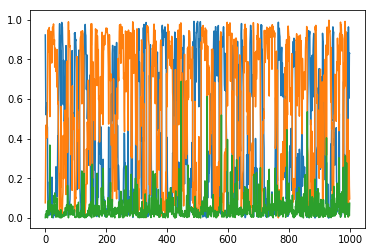

In [19]:
plt.plot(xi2[:, 99, :])

In [20]:
np.max(xi2)

0.9999099291298972

In [44]:
def likelihood_per_individual(ix, eta_curr, p_curr, ft_prev, xi_prev):
    xi_curr = eta_curr_per_ind * (tt.dot(p_curr_per_ind.T, xi_prev[0:2]))
    ft_curr = tt.sum(xi_curr)
    xi_curr = xi_curr/ft_curr
    return [ft_curr, xi_curr]

In [54]:
eta_curr = tt.dmatrix("eta_curr")
eta_curr.tag.test_value = eta0[0]
p_curr = tt.dtensor3("p_curr")
p_curr.tag.test_value = p[0]
xi_k_out = tt.dvector("xi_k_out")
xi_k_out.tag.test_value = np.array([1, 0, 0])
ft_k_out = tt.dscalar("ft_k_out")
ft_k_out.tag.test_value = np.array([0.])
print(eta0[:, 0, :].shape)
print(eta_curr.tag.test_value.shape)
ft_init = np.array([0] * 100)
xi_init = np.array([[1., 0., 0.]] * 100)
([ft_, Xi_], updates) = theano.scan(likelihood_per_individual,
                                  sequences=[eta_curr, p_curr],
                                  outputs_info=[ft_k_out, xi_k_out])
likelihood_per_individual_ = theano.function(inputs=[eta_curr, p_curr, ft_k_out, xi_k_out], 
                                             outputs=[ft_, Xi_], updates=updates)
test, test2 = likelihood_per_individual_(eta0[0], p[0], 0, np.array([1., 0., 0.]))

(1000, 3)
(100, 3)
(100,) (100, 3)


In [50]:


def likelihood(eta_curr, p_curr, ft, xi):
    ([ft_, Xi_], updates) = theano.scan(fn=likelihood_per_individual,
                                        sequences=tt.arange(eta_curr.shape[0]),
                                        non_sequences=[eta_curr, p_curr]
                                        outputs_info=[ft_k_out, xi_k_out])
    #likeli
    return [ft_, Xi_]

In [51]:

ft_k_out = tt.dscalar("ft_k_out")
ft_k_out = theano.shared(0.) 


In [52]:
p_ = tt.dtensor4("p_")
p_.tag.test_value = p
print(ft_out.tag.test_value.shape, xi_out.tag.test_value.shape)
print(ft_k_out)
([Ft, Xi], updates) = theano.scan(likelihood,
                                  sequences=[eta_, p_],
                                  outputs_info=[ft_out, xi_out])

(100,) (100, 3)
<TensorType(float64, scalar)>


In [53]:
likelihood_ = theano.function(inputs=[eta_, p_, ft_out, xi_out], 
                             outputs=[Ft, Xi], updates=updates)

MissingInputError: Input 5 of the graph (indices start from 0), used to compute for{cpu,scan_fn}(Elemwise{minimum,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, ft_k_out, xi_k_out), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.
 
Backtrace when that variable is created:

  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-52-1769e24cd7bb>", line 7, in <module>
    outputs_info=[ft_out, xi_out])
  File "/home/anurag/pymc3/lib/python3.6/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "<ipython-input-50-8b564b0e4592>", line 6, in likelihood
    ft_k_out = tt.dscalar("ft_k_out")


In [ ]:
xi_init = np.array([[1.0, 0., 0.]] * 100)

In [ ]:
ft_init = theano.shared(np.array([0.] * 100))

In [ ]:
ft1, xi1 = likelihood_(eta0, p, ft_init, xi_init)